In [91]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import kstest, jarque_bera, shapiro, ttest_1samp
from statsmodels.stats.diagnostic import acorr_ljungbox,het_arch, het_white
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (12,7)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = "--"
plt.rcParams['savefig.facecolor']='white'

# Przygotowanie danych

In [92]:
cocoa = pd.read_csv('Cocoa.csv')
milk = pd.read_csv('Milk.csv')
sugar = pd.read_csv('Sugar.csv')

In [93]:
cocoa['Date'] = pd.to_datetime(cocoa['Date'])
milk['Date'] = pd.to_datetime(milk['Date'])
sugar['Date'] = pd.to_datetime(sugar['Date'])

In [94]:
cocoa['Close/Last'] = cocoa['Close/Last'].astype(float)
milk['Close/Last'] = milk['Close/Last'].astype(float)
sugar['Close/Last'] = sugar['Close/Last'].astype(float)

In [95]:
pln_usd = pd.read_csv("PLNUSD=X.csv")

In [96]:
pln_usd = pln_usd[pln_usd["Close"].notnull()]

In [97]:
pln_usd.reset_index(inplace=True)

In [98]:
pln_usd["Date"] = pd.to_datetime(pln_usd["Date"])

In [99]:
dates = []
for i in range(len(pln_usd)):
    if pln_usd["Date"][i] not in list(cocoa["Date"]):
        dates.append(pln_usd["Date"][i])
    if pln_usd["Date"][i] not in list(milk["Date"]):
        dates.append(pln_usd["Date"][i])
    if pln_usd["Date"][i] not in list(sugar["Date"]):
        dates.append(pln_usd["Date"][i])

In [100]:
for i in range(len(cocoa)):
    if cocoa["Date"][i] not in list(pln_usd["Date"]):
        dates.append(cocoa["Date"][i])
    if sugar["Date"][i] not in list(pln_usd["Date"]):
        dates.append(sugar["Date"][i])

In [101]:
for i in range(len(milk)):
    if milk["Date"][i] not in list(pln_usd["Date"]):
        dates.append(milk["Date"][i])

In [102]:
dates = list(set(dates))

In [103]:
for i in range(len(dates)):
    pln_usd = pln_usd[pln_usd["Date"] !=  dates[i]]
    cocoa = cocoa[cocoa["Date"] !=  dates[i]]
    milk = milk[milk["Date"] !=  dates[i]]
    sugar = sugar[sugar["Date"] !=  dates[i]]

In [104]:
pln_usd = pln_usd[::-1]

In [105]:
pln_usd.reset_index(inplace=True)
cocoa.reset_index(inplace=True)
milk.reset_index(inplace=True)
sugar.reset_index(inplace=True)

Zamiana danych na stopy procentowe.

In [106]:
T = 1/252
cocoa_close = np.array([round((cocoa['Close/Last'][i] - cocoa['Close/Last'][i+1])/(cocoa['Close/Last'][i+1] * T),3) for i in range(len(cocoa)-1)])
milk_close = np.array([round((milk['Close/Last'][i] - milk['Close/Last'][i+1])/(milk['Close/Last'][i+1] * T), 3) for i in range(len(milk)-1)])
sugar_close = np.array([round((sugar['Close/Last'][i] - sugar['Close/Last'][i+1])/(sugar['Close/Last'][i+1] * T), 3) for i in range(len(sugar)-1)])

In [107]:
cocoa_close /= -100
milk_close /= -100
sugar_close /= -100

# 1. Estymacja średnich, odchyleń standardowych i korelacji

In [108]:
mu_c = np.mean(cocoa_close)
sigma_c = np.std(cocoa_close)
print(mu_c, sigma_c)

mu_m = np.mean(milk_close)
sigma_m = np.std(milk_close)
print(mu_m, sigma_m)

mu_s = np.mean(sugar_close)
sigma_s = np.std(sugar_close)
print(mu_s, sigma_s)

-0.0011226437699680513 0.046895540026747284
-0.0017608067092651758 0.06315052203248535
-0.0007991214057507985 0.0481337056540928


In [109]:
n = len(cocoa_close)
C = cocoa_close.reshape(1,n)
M = milk_close.reshape(1,n)
S = sugar_close.reshape(1,n)
R = np.concatenate([C,M,S],axis=0)

In [110]:
corr = np.corrcoef(R)

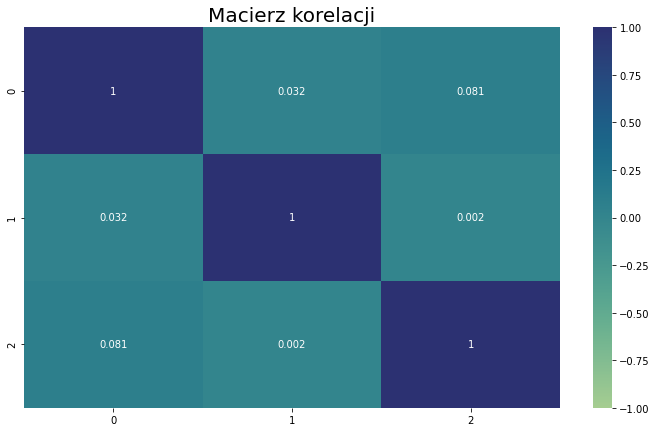

In [139]:
sns.heatmap(corr, annot=True, cmap="crest", vmin=-1, vmax=1)
plt.title("Macierz korelacji", fontsize=20)
plt.show()

## a) stopa zwrotu i ryzyko portfela z rzeczywistymi wagami 

In [46]:
Rp = 0.5 * cocoa_close + 0.2 * milk_close + 0.3 * sugar_close

In [112]:
w = np.array([0.5, 0.2, 0.3])
print("Stopa zwrotu porfela: {}, ryzyko portfela: {}.".format(w[0]*mu_c + w[1]*mu_m + w[2]*mu_s, np.sqrt(np.dot(w.T, np.dot(np.cov(R), w)))))

Stopa zwrotu porfela: -0.0011532196485623003, ryzyko portfela: 0.03151053404357198.


## b) możliwe portfele dla różnych wag

In [113]:
param_list = np.arange(0,1.1,0.05)

In [114]:
combinations = []
for j in range(len(param_list)-1):
    for i in range(len(param_list)-1):
        vec = np.array([param_list[j], param_list[i], round(1-param_list[i]-param_list[j],2)])
        if (vec >= 0).sum() == vec.size and (vec <= 1).sum() == vec.size:
            combinations.append(vec)


In [115]:
expected_values = []
standard_deviations = []

for w in combinations:
    expected_values.append(w[0] * mu_c + w[1] * mu_m + w[2] * mu_s)
    standard_deviations.append(np.sqrt(np.dot(w.T, np.dot(np.cov(R), w))))

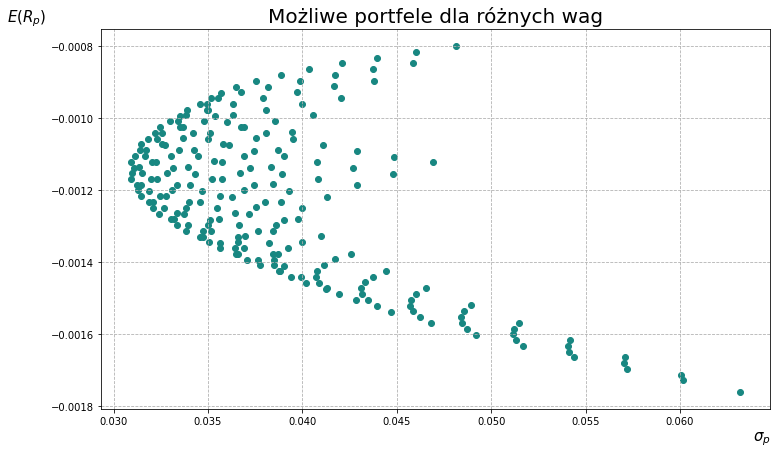

In [116]:
plt.scatter(standard_deviations, expected_values, color="#188781")
plt.title("Możliwe portfele dla różnych wag", fontsize=20)
plt.xlabel(r"$\sigma_p$", fontsize=15, loc="right")
plt.ylabel(r"$E(R_p)$", fontsize=15, rotation=0, loc="top")
plt.show()

## c) portfel o minimalnym ryzyku

In [117]:
standard_deviations.index(min(standard_deviations))

145

In [118]:
expected_values[132], standard_deviations[145], combinations[145]

(-0.0012008598242811504, 0.03093033018147968, array([0.4 , 0.25, 0.35]))

In [119]:
# Sprawdzamy czy zachodzą warunki

print(corr[0,1] <= min(sigma_c/sigma_m, sigma_m/sigma_c))
print(corr[0,2] <= min(sigma_c/sigma_s, sigma_s/sigma_c))
print(corr[1,2] <= min(sigma_m/sigma_s, sigma_s/sigma_m))

True
True
True


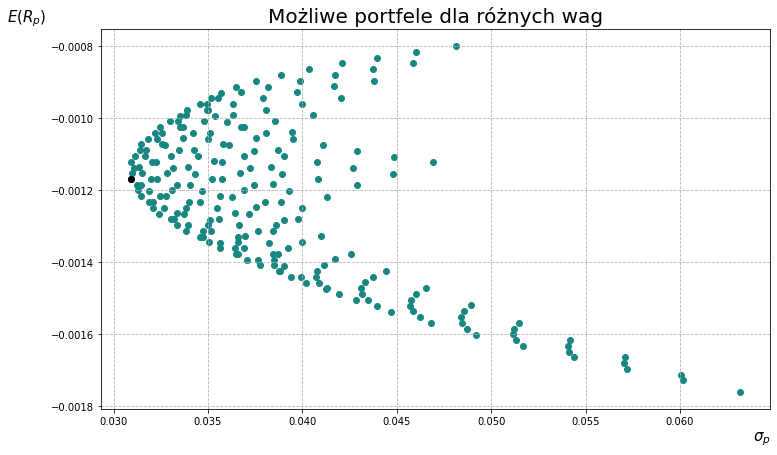

In [120]:
plt.scatter(standard_deviations, expected_values, color="#188781")
plt.scatter(standard_deviations[145], expected_values[145], color='k')
plt.title("Możliwe portfele dla różnych wag", fontsize=20)
plt.xlabel(r"$\sigma_p$", fontsize=15, loc="right")
plt.ylabel(r"$E(R_p)$", fontsize=15, rotation=0, loc="top")
plt.show()

## d) portfel o minimalnym ryzyku przy ustalonej stopie zwrotu

In [121]:
# ustalona stopa zwrotu
r = -0.0012

In [122]:
exp = np.array(expected_values).round(5)
ind = np.where(exp == r)[0].tolist()

In [130]:
standard_deviations.index(min([standard_deviations[i] for i in ind]))

132

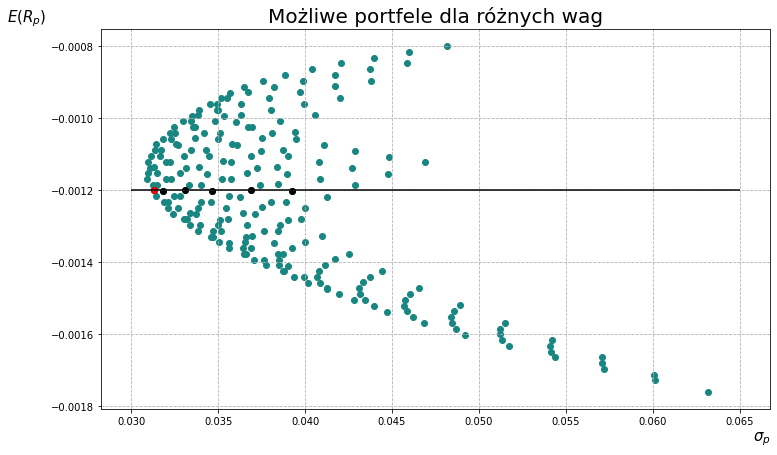

In [132]:
plt.scatter(standard_deviations, expected_values, color="#188781")
plt.hlines(r, xmin=0.03, xmax=0.065, color='k')
plt.scatter([standard_deviations[i] for i in ind], [expected_values[i] for i in ind], color='k')
plt.scatter(standard_deviations[132], expected_values[132], color='red')
plt.title("Możliwe portfele dla różnych wag", fontsize=20)
plt.xlabel(r"$\sigma_p$", fontsize=15, loc="right")
plt.ylabel(r"$E(R_p)$", fontsize=15, rotation=0, loc="top")
plt.show()

In [133]:
expected_values[132], standard_deviations[132], combinations[132]

(-0.0012008598242811504, 0.03128430412826036, array([0.35, 0.3 , 0.35]))

## e) portfel rynkowy

In [134]:
x = ((np.array(expected_values) - r)/np.array(standard_deviations)).tolist()

In [135]:
x.index(max(x))

41

In [136]:
expected_values[41], standard_deviations[41], combinations[41]

(-0.0008314736421725238, 0.04396472266471058, array([0.1, 0. , 0.9]))

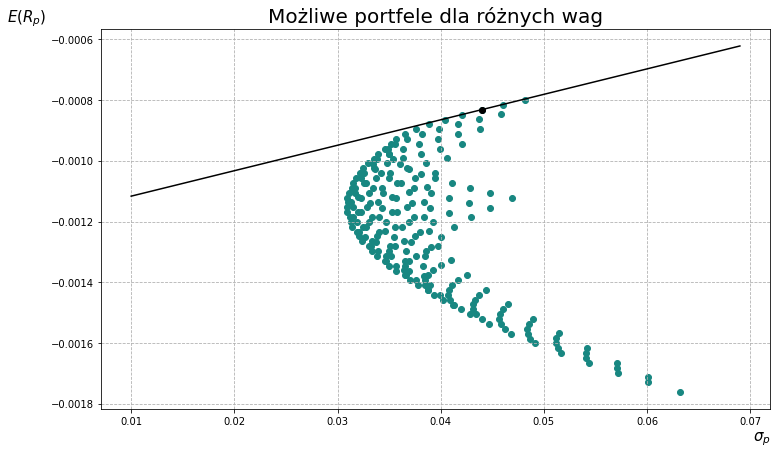

In [137]:
plt.scatter(standard_deviations, expected_values, color="#188781")
plt.plot(np.arange(0.01,0.07,0.001), np.arange(0.01,0.07,0.001) * max(x) + r, color='k')
plt.scatter(standard_deviations[41], expected_values[41], color='k')
plt.title("Możliwe portfele dla różnych wag", fontsize=20)
plt.xlabel(r"$\sigma_p$", fontsize=15, loc="right")
plt.ylabel(r"$E(R_p)$", fontsize=15, rotation=0, loc="top")
plt.show()

# Model jednowskaźnikowy

## Kakao

In [66]:
pln_usd['MonthlyAverage'] = (pln_usd.groupby(pln_usd['Date'].dt.to_period('M'))
                          ['Close'].transform('mean')
                       )

In [67]:
pln_usd_close = pln_usd['Close']/pln_usd['MonthlyAverage']

In [68]:
cocoa['MonthlyAverage'] = (cocoa.groupby(cocoa['Date'].dt.to_period('M'))
                          ['Close/Last'].transform('mean'))

In [69]:
cocoa_close = cocoa['Close/Last']/cocoa['MonthlyAverage']

In [70]:
# cocoa_close2 = np.array([round((cocoa_close[i] - cocoa_close[i+1])/(cocoa_close[i+1] * T),3) for i in range(len(cocoa_close)-1)])
# pln_usd_close2 = np.array([round((pln_usd_close[i] - pln_usd_close[i+1])/(pln_usd_close[i+1] * T),3) for i in range(len(pln_usd_close)-1)])

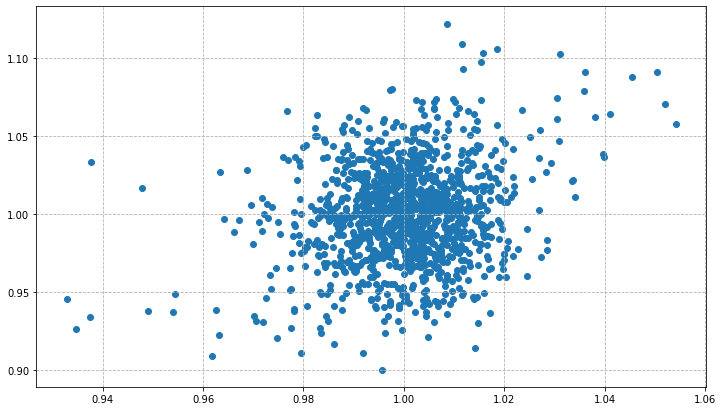

In [71]:
plt.scatter(pln_usd_close,cocoa_close)
plt.show()

In [72]:
y = cocoa_close
x = pln_usd_close

In [73]:
x = sm.add_constant(x)

In [74]:
model = sm.GLS(y, x).fit()

In [75]:
print(model.summary())

                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.049
Model:                            GLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     64.55
Date:                Mon, 09 May 2022   Prob (F-statistic):           2.16e-15
Time:                        10:14:33   Log-Likelihood:                 2566.9
No. Observations:                1253   AIC:                            -5130.
Df Residuals:                    1251   BIC:                            -5120.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4289      0.071      6.033      0.0

In [76]:
alpha = model.params['const']
beta = model.params[0]

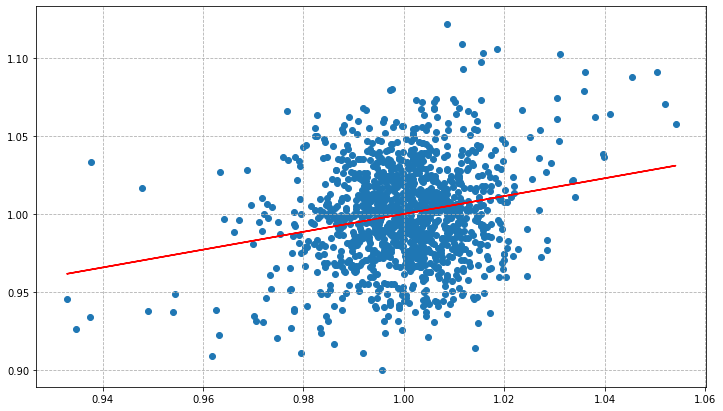

In [77]:
plt.scatter(pln_usd_close,cocoa_close)
plt.plot(pln_usd_close,pln_usd_close*beta + alpha,color='red')
plt.show()

In [78]:
epsilon = model.resid

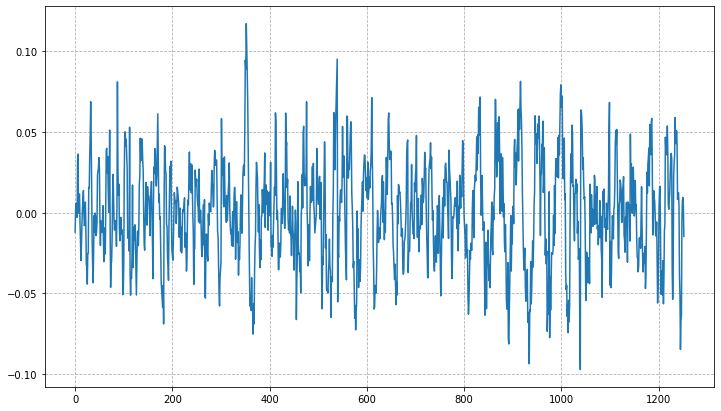

In [79]:
plt.plot(epsilon)
plt.show()

In [80]:
het_arch(epsilon)

(502.0972685397063,
 1.5730076437600587e-101,
 83.49055936421114,
 6.21237381396699e-131)

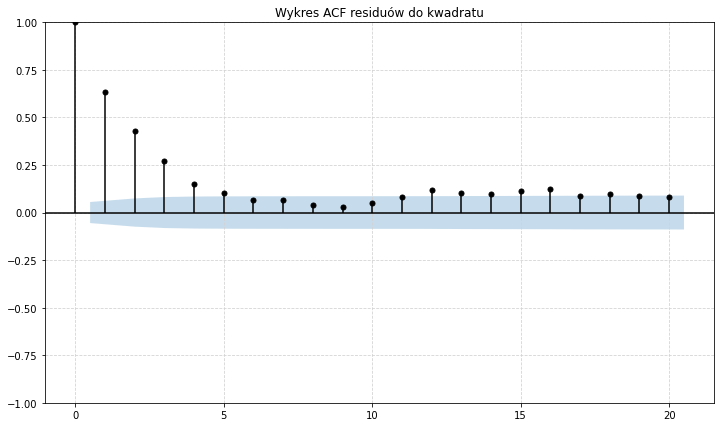

In [81]:
plot_acf(np.array(epsilon)**2, lags=20, color="k", vlines_kwargs={"colors": "k"}, title="Wykres ACF residuów do kwadratu")
plt.grid(color='lightgray',linestyle='--')
plt.show()

In [82]:
acorr_ljungbox(epsilon,lags=[30],return_df=True)

,lb_stat,lb_pvalue
30,2715.195013,0.0


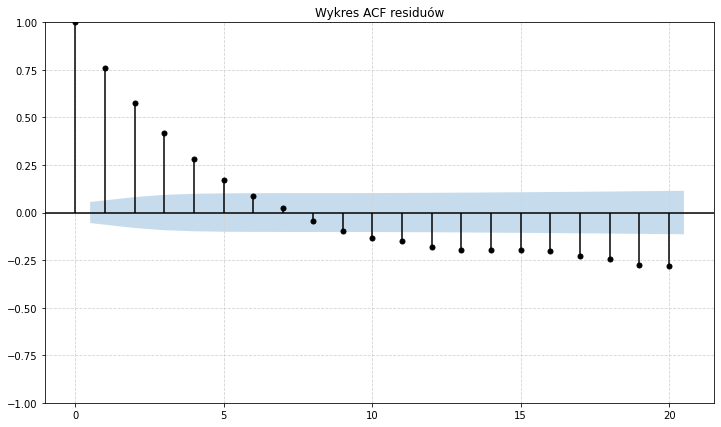

In [83]:
plot_acf(np.array(epsilon), lags=20, color="k", vlines_kwargs={"colors": "k"}, title="Wykres ACF residuów")
plt.grid(color='lightgray',linestyle='--')
plt.show()

In [84]:
print("Test Kołmogorowa-Smirnowa: {}.".format(kstest( (epsilon-epsilon.mean())/epsilon.std() , 'norm').pvalue))
print("Test Jarque-Bera: {}.".format(jarque_bera(epsilon).pvalue))
print("Test Shapiro-Wilka: {}.".format(shapiro(epsilon).pvalue))

Test Kołmogorowa-Smirnowa: 0.9581850818128141.
Test Jarque-Bera: 0.4962909699053375.
Test Shapiro-Wilka: 0.7062000632286072.


In [85]:
ttest_1samp(epsilon, 0)

Ttest_1sampResult(statistic=7.464633846589913e-13, pvalue=0.9999999999994045)

## Mleko